<a href="https://colab.research.google.com/github/khakhiD/ML/blob/main/Doraemon_Classification/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

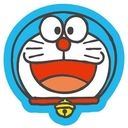
# **도라에몽 찾기 👀**
---
>**⚡ 머신러닝 프로그래밍 (이창열 교수님) 기말 과제 ⚡**
- 도라에몽 이미지와 단팥빵 이미지 중, 도라에몽을 찾는 모델을 구성하고, 테스트하기
-  **ResNet50** Pre-trained model을 활용하여 전이 학습하기  


### **참여자**
---
>- 신동호, 김태근, 허정현, 서혜윰


### **과정**
---


>- 데이터 불러오기
- 데이터 전처리
- 모델 구성
- 모델 학습
- 테스트

### **데이터 불러오기**


In [8]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from PIL import Image

from keras.preprocessing.image import img_to_array, load_img
from keras.applications.resnet import preprocess_input
from keras.applications.resnet import ResNet50
from keras import models, layers
from keras.models import Model

---
- 필요 라이브러리들을 Import 과정입니다.
Keras의 **ResNet50** 모델이 핵심입니다.

In [1]:
# 이미지 데이터 크롭용 함수
"""
  본 문서에서 활용하는 데이터는 이미 아래 함수가 적용되었습니다.
"""
import os, sys

def resize_and_crop(img_path, modified_path, size, crop_type='middle'):
    files = os.listdir(img_path)
    for file in files: 
        name = str(file)
        os.chdir(img_path)
        img = Image.open(file)
        img_ratio = img.size[0] / float(img.size[1])
        ratio = size[0] / float(size[1])
        
        if ratio > img_ratio:
            img = img.resize((size[0], int(round(size[0] * img.size[1] / img.size[0]))),
                Image.ANTIALIAS)     
            if crop_type == 'top':
                box = (0, 0, img.size[0], size[1])
            elif crop_type == 'middle':
                box = (0, int(round((img.size[1] - size[1]) / 2)), img.size[0],
                    int(round((img.size[1] + size[1]) / 2)))
            elif crop_type == 'bottom':
                box = (0, img.size[1] - size[1], img.size[0], img.size[1])
            else :
                raise ValueError('ERROR: invalid value for crop_type')
            img = img.crop(box)
            
        elif ratio < img_ratio:
            img = img.resize((int(round(size[1] * img.size[0] / img.size[1])), size[1]),
                Image.ANTIALIAS)
            if crop_type == 'top':
                box = (0, 0, size[0], img.size[1])
            elif crop_type == 'middle':
                box = (int(round((img.size[0] - size[0]) / 2)), 0,
                    int(round((img.size[0] + size[0]) / 2)), img.size[1])
            elif crop_type == 'bottom':
                box = (img.size[0] - size[0], 0, img.size[0], img.size[1])
            else :
                raise ValueError('ERROR: invalid value for crop_type')
            img = img.crop(box)
            
        else :
            img = img.resize((size[0], size[1]), Image.ANTIALIAS)
            
        os.chdir(modified_path)
        img.save(name, "png")

---
- 이미지 크롭/리사이징용 함수입니다.
- 사용할 커스텀 데이터는 파이썬 웹스크래핑을 통해 구성하였기 때문에, 각 이미지의 크기가 제각각이었습니다.
- Github에 업로드되어 본문에 사용되는 데이터는 이미 해당 함수를 통해 크롭된 이미지입니다.

In [10]:
# 이미지 배열 확인용 함수 - 예제 함수 그대로 사용
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

훈련용 도라에몽, 단팥빵 이미지 (30장, 사이즈=(100,100))


<Figure size 432x288 with 0 Axes>

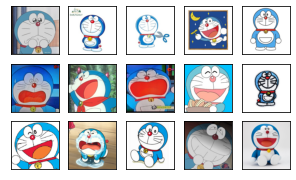

<Figure size 432x288 with 0 Axes>

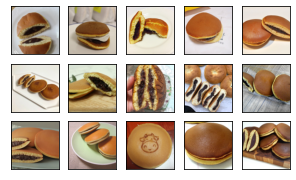

In [33]:
# 훈련 데이터: 15장의 도라에몽 이미지 + 15장의 단팥빵 이미지
import urllib.request

doraemon_images = []
dorayaki_images = []

url = 'https://github.com/khakhiD/ML/raw/main/data/'

for i in range(15):
  urllib.request.urlretrieve(url+'doraemon/doraemon%20({}).jpg'.format(i+1),
                             "doraemon{}.jpg".format(i+1))
  img = Image.open("doraemon{}.jpg".format(i+1)).convert('RGB')
  img = img.resize((100,100))
  img = np.asarray(img)
  doraemon_images.append(img)

for i in range(15):
  urllib.request.urlretrieve(url+'dorayaki/dorayaki%20({}).jpg'.format(i+1),
                             "dorayaki{}.jpg".format(i+1))
  img = Image.open("dorayaki{}.jpg".format(i+1)).convert('RGB')
  img = img.resize((100,100))
  img = np.asarray(img)
  dorayaki_images.append(img)

print("훈련용 도라에몽, 단팥빵 이미지 (30장, 사이즈=(100,100))")
plot_images(3,5, doraemon_images)
plot_images(3,5, dorayaki_images)

In [34]:
print(len(doraemon_images))
print(len(dorayaki_images))

15
15


---
- 활용할 데이터를 Github(https://github.com/khakhiD/ML/tree/main/data) 에 업로드하였습니다.
- 훈련용 데이터인 15장의 도라에몽 이미지와 15장의 단팥빵 이미지를 불러와 각 배열에 저장합니다.
- 모델 훈련을 위해 사용할 Image shape은 (100,100,3)이므로, 이미지를 resize 해줍니다.
- **✅ PIL 라이브러리를 활용하여 모든 이미지를 'RGB'로 맞추었습니다.**

### **데이터 전처리**

In [35]:
# Training Set 구성하기
X = doraemon_images + dorayaki_images
y = [[1]]*len(doraemon_images) + [[0]]*len(dorayaki_images)

X = np.array(X)
y = np.array(y)
X = preprocess_input(X)

print(X.shape, y.shape)

(30, 100, 100, 3) (30, 1)


---
- X에 도라에몽 이미지와 단팥빵 이미지를 붙여 넣어줍니다.
- y는 도라에몽 이미지인 경우 1, 단팥빵 이미지일 경우 0인 이진 형태로 구성해줍니다.
- X와 y를 넘파이 배열로 변환합니다.
- keras.applications.resnet의 **preprocess_input 함수**로 **ResNet 전용 전처리**를 해줍니다.

### **모델 구성**

---
- 기학습(pre-trained) 모델에 우리가 사용할 레이어를 추가하여 모델을 구성하는 과정입니다.

In [36]:
# ResNet50의 ImageNet 가중치를 가지고 있는 모델을 전이학습으로 사용

input_layer = layers.Input(shape=(100,100,3))
base_model = ResNet50(weights='imagenet', input_tensor=input_layer, include_top=False)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']      

---
- imagenet 가중치가 학습된 ResNet50 모델의 레이어 구성입니다.
- include_top을 False로 주어, 사전학습 모델의 최상층 분류기를 사용하지 않도록 설정합니다.
- 해당 모델 레이어 구성 다음에 들어갈 레이어를 구성하여 붙여줄 것입니다.

In [37]:
# Freeze 하기
for layer in base_model.layers[:-1]:
  layer.trainable = False

# 다음 레이어 구성하기
last_layer = base_model.output
flatten_layer = layers.Flatten()(last_layer)
dense_layer = layers.Dense(256, activation='relu')(flatten_layer)
dense_layer = layers.Dense(256, activation='relu')(dense_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dense_layer)

# ResNet 모델과 구성한 모델 붙이기
Dora_model = Model(inputs=input_layer, outputs=output_layer)
Dora_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

---
- 기존 ResNet 모델 레이어 이후 Flatten, Dense, Dense, Dense 레이어가 추가되었습니다.
- 이미지가 도라에몽 이미지인지 단팥빵 이미지인지 이진 분류할 것이므로, 마지막 Dense Layer에 **Sigmoid 함수**를 적용하여 입력 값을 0 또는 1로 변형하여 출력합니다.


In [39]:
Dora_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print("\'Dora_model\' has been compiled.")

'Dora_model' has been compiled.


---
- 기존 예제와 같이 손실함수는 Mean Squared Error, 활성화 함수는 Adam으로 설정하여 컴파일합니다.

###**모델 학습**

In [40]:
# 구성한 모델과 데이터로 이미지를 학습
history = Dora_model.fit(X, y, epochs=50, shuffle=True)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2105 - accuracy: 0.7333
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.0035 - accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/50
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/50
1/1 [

---
- 데이터가 ordered (1111...0000...) 되어 있기 때문에 shuffle=True를 주어 모델을 학습합니다.

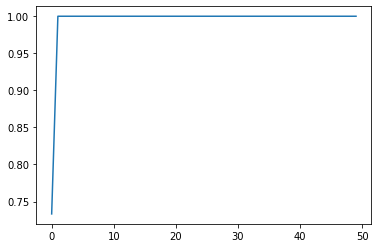

In [41]:
plt.plot(history.history['accuracy'])

###**테스트**

---
- 먼저, **테스트 이미지셋을 구성**합니다.
- 총 10장의 테스트 이미지셋은 도라에몽 이미지 5장, 단팥빵 이미지 5장으로 구성되어 있습니다.


<Figure size 432x288 with 0 Axes>

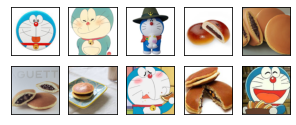

In [27]:
# 테스트용 이미지 10장을 구성

test_images = []

url = 'https://github.com/khakhiD/ML/raw/main/data/test/emon_or_yaki/'

for i in range(10):
  urllib.request.urlretrieve(url+'doratest%20({}).jpg'.format(i+1), "doratest{}.jpg".format(i+1))
  img = Image.open("doratest{}.jpg".format(i+1)).convert('RGB')
  img = img.resize((100,100))
  img = np.asarray(img)
  test_images.append(img)

test_images = np.array(test_images)
plot_images(2,5, test_images)

---
- 테스트 셋의 정답은 **[1,1,1,0,0,0,0,1,0,1]**이 될 것입니다.

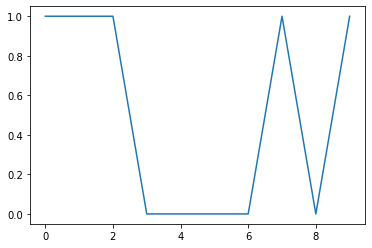

In [44]:
# 예측하기

test_result = Dora_model.predict(test_images)
plt.plot(test_result)

---
- 정답과 일치하는 결과가 나왔습니다.

<Figure size 432x288 with 0 Axes>

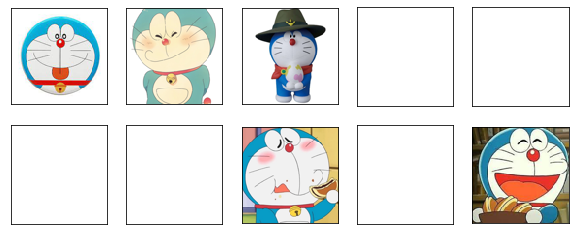

In [43]:
# 예측 결과 시각화하기

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

---
- 도라에몽 이미지만을 찾아내었습니다.